In [1]:
#import plotly.plotly as py
#import plotly.graph_objs as go
# The above two are optional if you wish to execute the last segment of the code
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from mpl_toolkits.mplot3d import Axes3D


In [2]:
## Q1
# Read input image
filename = 'target.jpg'
ImRGB = np.double(plt.imread(filename))

# Compute feature vectors for each pixel
featureMatrix = np.zeros((len(ImRGB), len(ImRGB[0]), 5), np.double)

for r in range(len(ImRGB)):
    for c in range(len(ImRGB[0])):
        featureMatrix[r,c,range(2)] = [c,r] # Because feature matrix has <x,y,R,G,B>
        featureMatrix[r,c,range(2,5)] = ImRGB[r,c,:]

        
modelCovMatrix = [[ 47.917,0, -146.636, -141.572, -123.269],
                  [ 0, 408.250, 68.487, 69.828, 53.479],
                  [-146.636, 68.487, 2654.285, 2621.672, 2440.381],
                  [-141.572, 69.828, 2621.672, 2597.818, 2435.368],
                  [-123.269, 53.479, 2440.381, 2435.368, 2404.923]]


In [3]:
# Compute distance in Riemannian Manifold space
def computeDistance(Cmodel, Ccandidate):
    [eigenValues, eigVec] = eig(Cmodel, Ccandidate)
    logEigVals = np.log(eigenValues)
    # Sometimes EigenValues might be complex. But we need not worry
    # because when we take square and add they would sum to zero.
    # But even after that, we should return the real part of the result
    return (np.sqrt(np.sum(np.square(logEigVals).real)))
    

In [4]:
# Compute covariance matrix for each patch and find distance from modelCovMatrix
rowsPatch = 70
colsPatch = 24

distMatrix = np.zeros((len(ImRGB) - rowsPatch + 1, len(ImRGB[0]) - colsPatch + 1)
                      , np.double)

# Iterate over patches
for r in range(len(ImRGB) - rowsPatch + 1):
    for c in range(len(ImRGB[0]) - colsPatch + 1):
        patchMatrix = featureMatrix[r: r + rowsPatch, c: c + colsPatch, :]
        # Reshape to get a matrix of size 5 x (70*24)
        patchVector = patchMatrix.transpose(2,0,1).reshape(5,-1)
        covPatch = np.cov(patchVector,bias=True)
        distMatrix[r,c] = computeDistance(covPatch, modelCovMatrix)
        

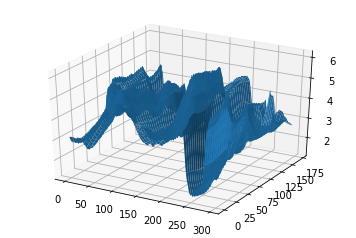

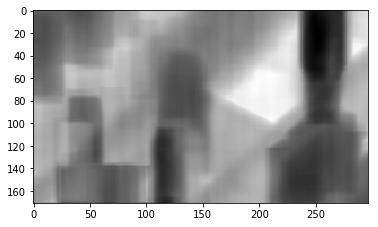

In [5]:
x = range(len(distMatrix[0]))
y = range(len(distMatrix))
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)

ha.plot_surface(X, Y, distMatrix)

plt.show()

plt.imshow(distMatrix/255.0, cmap='gray')
plt.show()

The above plot shows the distance for each patch(Riemannian Manifold space) in 2D and 3D.

top-left index(0-based indexing) of box with minimum value (23, 251)


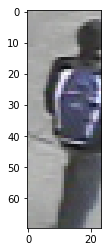

In [6]:
positionMax = np.unravel_index(distMatrix.argmin(), distMatrix.shape)
print('top-left index(0-based indexing) of box with minimum value', positionMax)
plt.imshow(ImRGB[positionMax[0] : positionMax[0] + rowsPatch, 
                positionMax[1] : positionMax[1] + colsPatch, :]/255.0)
plt.show()

In [7]:
## Q2
# Function to compute distance between two points
def dist(r,c,R0,C0):
    distance = np.sqrt(np.square(r-R0) + np.square(c-C0))
    return distance
    
# Get circular neighbors within radius
def circularNeighbors(img,R0,C0,radius):
    lowerR = int(np.floor(R0 - radius))
    upperR = int(np.ceil(R0 + radius))
    lowerC = int(np.floor(C0 - radius))
    upperC = int(np.ceil(C0 + radius))
    X = []
    for r in range(lowerR, upperR + 1):
        for c in range(lowerC, upperC + 1):
            if dist(r,c,R0,C0) <= radius:
                X.append([r, c, img[r,c,0], img[r,c,1], img[r,c,2]])
    
    return np.array(X)

circle = circularNeighbors(ImRGB, 25,25,5)

In [8]:
## Q3
# Compute bin index.
# This function requires 256 to be divisible by bins
def getBin(val, bins):
    binLength = int(256 / bins)
    binIndex = int(val / binLength)
    return binIndex

# Function to compute Epanechnikov Profile
def getEpanechnikovProfile(r, c, R0, C0, bandwidth):
    r = dist(r,c,R0,C0) / bandwidth
    r = r*r
    if r < 1.0:
        r = 1.0 - r
    else:
        r = 0.0
    return r

# Compute weighted histogram
def colorHistogram(X, bins, R0, C0, bandwidth):
    neighbors = circularNeighbors(X, R0, C0, bandwidth)
    hist = np.zeros((bins, bins, bins), np.double)
    for pt in range(len(neighbors)):
        Rbin = getBin(neighbors[pt][2], bins)
        Gbin = getBin(neighbors[pt][3], bins)
        Bbin = getBin(neighbors[pt][4], bins)
        hist[Rbin, Gbin, Bbin] += getEpanechnikovProfile(neighbors[pt][0]
                                , neighbors[pt][1], R0, C0, bandwidth)
    
    # Normalize histogram to convert to PDF
    histSum = hist.sum()
    
    hist = hist / histSum
    return hist
        

In [9]:
# Check if the getBin function is working correctly
print(getBin(0,4), getBin(255,4), getBin(0,8), getBin(255,8), getBin(0,16)
      , getBin(255,16))


0 3 0 7 0 15


In [10]:
## Q4
# Compute Mean-Shift weights
def meanShiftWeights(X,q_model,p_test, bins, R0, C0, bandwidth):
    # Get neighboring pixels
    neighbors = circularNeighbors(X, R0, C0, bandwidth)
    weights = np.zeros(len(neighbors), np.double)
    
    for pt in range(len(neighbors)):
        Rbin = getBin(neighbors[pt][2], bins)
        Gbin = getBin(neighbors[pt][3], bins)
        Bbin = getBin(neighbors[pt][4], bins)
        weights[pt] = np.sqrt(q_model[Rbin, Gbin, Bbin] / p_test[Rbin, Gbin, Bbin])
    
    return weights
         

In [11]:
## Q5
# Load the two images
Img1 = np.double(plt.imread('img1.jpg'))
Img2 = np.double(plt.imread('img2.jpg'))

radius = 25.0
R0 = 175.0
C0 = 150.0
bins = 16
numIterations = 25

# Compute Model
q_model = colorHistogram(Img1, bins, R0, C0, radius)

# Starting position
Yprevious = [R0, C0]

# Store Y position for each iteration
Yall = []
Yall.append(Yprevious)

# Iterate 25 times
for it in range(numIterations):
    # Compute weights
    p_test = colorHistogram(Img2, bins, Yprevious[0], Yprevious[1], radius)

    # Compute next best location
    neighbors = circularNeighbors(Img2, Yprevious[0], Yprevious[1], radius)
    numerator = np.zeros(2,np.double)
    denominator = 0.0
    # Compute weights
    weights = meanShiftWeights(Img2, q_model, p_test, bins, Yprevious[0], Yprevious[1]
                               , radius)
    for pt in range(len(neighbors)):
        numerator += (neighbors[pt][0:2] * weights[pt])
        denominator += weights[pt]

    # Compute new position
    Ynew = numerator / denominator
    Yprevious = Ynew
    Yall.append(Yprevious)

# Final location
print('The final (x,y) location is ', Yall[-1][1], Yall[-1][0])
    
# Euclidean Distance of last two iterations
distance1 = dist(Yall[-1][0], Yall[-1][1], Yall[-2][0], Yall[-2][1])
distance2 = dist(Yall[-2][0], Yall[-2][1], Yall[-3][0], Yall[-3][1])
print('Euclidean Distance of last Iteration = ', distance1)
print('Euclidean Distance of second last Iteration = ', distance2)


The final (x,y) location is  141.12299410707968 174.9403629445637
Euclidean Distance of last Iteration =  9.222297701160323e-06
Euclidean Distance of second last Iteration =  1.5107502512449305e-05


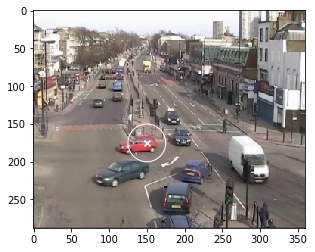

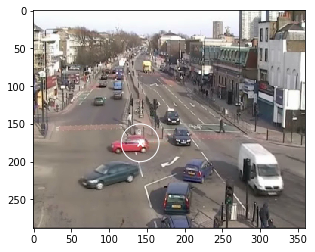

In [12]:
#plt.subplot(121)
fig, ax = plt.subplots()
plt.imshow(Img1/255.0)
plt.scatter(C0, R0, c='white', marker='x')
circle1 = plt.Circle((C0, R0), 25, color='w', fill=False)
ax.add_artist(circle1)
plt.show()

fig, ax = plt.subplots()
plt.imshow(Img2/255.0)
plt.scatter(Yall[-1][1], Yall[-1][0], c='white', marker='x')
circle1 = plt.Circle((Yall[-1][1], Yall[-1][0]), 25, color='w', fill=False)
ax.add_artist(circle1)
plt.show()


The Mean-shift tracking seems to work pretty well and is very fast as compared to previous technique(covariance tracking).

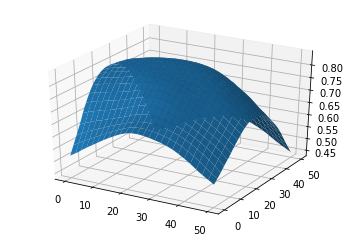

In [13]:
# NOTE: The below code is extra from the assignment and will take a couple of minutes.
# If you wish to execute the second part of this, install plotly

# Function to compute Bhattacharyya Coefficient
def computeBhattacharyyaCoefficient(q, p, bins):
    cost = 0.0
    for R in range(0,bins):
        for G in range(0,bins):
            for B in range(0,bins):
                cost += np.sqrt(p[R,G,B]*q[R,G,B])
        
    return cost

# 3D plot of cost
costMatrix = np.zeros((51,51), np.double)
R=Yall[-1][0]
C=Yall[-1][1]
for r in range(int(R-25), int(R+26)):
    for c in range(int(C-25), int(C+26)):
        p_test = colorHistogram(Img2, bins, r, c, radius)
        costMatrix[r-int(R)+25, c-int(C)+25] = computeBhattacharyyaCoefficient(q_model
                                                                    , p_test, bins)

x = range(len(costMatrix[0]))
y = range(len(costMatrix))
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)

ha.plot_surface(X, Y, costMatrix)

plt.show()

In [ ]:
py.sign_in('Python-Demo-Account', 'gwt101uhh0')
    
x = range(len(costMatrix[0]))
y = range(len(costMatrix))
X, Y = np.meshgrid(x, y)
surface = go.Surface(x=X, y=Y, z=costMatrix)
data=[surface]
fig = go.Figure(data=data)

py.iplot(fig,filename='3d')
# The result of this section is present in the folder 3DBhattCoeff1 and 2.png